In [1]:
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras import layers, callbacks

from keras.utils import to_categorical

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot

from scipy.stats import norm
from scipy import stats
import os

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pickle
import dataframe_image as dfi

#### Save parameters

In [2]:
time_data_amount = 18
nr_classes = 3

using_weights = False

In [3]:
name = 'one_channel_test' #name of model - should be descriptive
save_folder = 'template_' + str(time_data_amount) #hyperparameter description her
if using_weights == True:
    save_folder = save_folder + '_W'
    name = name + '_weighted'

### Gotta load in some data

In [4]:
datapath = '../../../All generated data/'
labelpath = '../../../All generated labels/'
data_list = os.listdir(datapath)
#print(data_list)

#all_data = [] #if we want to have data and labels in one list
all_datapoints = []
all_labels = []

total_channels = 79
total_scans_pr_sample = 20
classes = 3


for csv_file in data_list:
    data_file = datapath + csv_file
    current_data_file = pd.read_csv(data_file,header=None)

    label_file = labelpath + csv_file
    label_file = label_file.replace('.csv', '_labels.csv')
    current_label_file = pd.read_csv(label_file,header=None)

    for data_iter in range(len(current_data_file.index)):
        #Pulling out the data from a row and putting it in the list
        current_data_point = np.array(current_data_file.iloc[data_iter])
        current_data_point = current_data_point.reshape(total_scans_pr_sample,total_channels)
        all_datapoints.append(current_data_point)
        
        #adding the label to the datamatrix as the last row
        label_row = np.array(current_label_file.iloc[data_iter])
        label_row = label_row.reshape(1,total_channels)
        all_labels.append(label_row)
        
        #all_data.append(np.vstack([current_data_point, label_row])) #if we want to have data and labels in one list


In [5]:
print(all_labels[1].shape)
print(len(all_labels))
print(len(all_datapoints))

(1, 79)
10981
10981


#### Pick out one channel for each sample
For now it takes the same channel for all samples

In [6]:
chosen_channels = list(range(1,78,3))

complete_data = []
complete_labels = []

for iter in range(len(all_datapoints)):
    for channel in chosen_channels:
        complete_data.append(all_datapoints[iter][0:time_data_amount,channel])
        complete_labels.append(all_labels[iter][:,channel])
    

#quick check to make sure it works
print(complete_data[1].shape)
print(len(complete_data))
print(complete_labels[1].shape)
print(len(complete_labels))

(18,)
285506
(1,)
285506


### Splits data in train and test

In [7]:
data_train, data_test, labels_train, labels_test = train_test_split(complete_data, complete_labels, train_size=0.8, random_state=112)

# One hot encoding
labels_test = to_categorical(labels_test)
labels_train = to_categorical(labels_train)

data_train = np.array(data_train)
data_test = np.array(data_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)
print(labels_test.shape)

(57102, 3)


### Normalise data a bit

In [8]:
# Make a scaler from training data
scaler = preprocessing.StandardScaler().fit(data_train)

# scale everything using that scaler
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

### Stuff for class weights

In [9]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [10]:
class_weights = generate_class_weights(labels_train, multi_class=False, one_hot_encoded=True)

## Building a model

In [11]:
signal_size = time_data_amount

y = layers.Input(shape=(signal_size,1), dtype='float32', name='Input')

x = layers.Conv1D(16, 6, padding='same', activation='relu', use_bias=True)(y)
#x = layers.Dropout(rate=0.1)(x)

x = layers.Conv1D(16, 3, padding='valid', activation='relu')(x)

'''
x = layers.MaxPool1D(pool_size=3,strides=1)(x)
#x = layers.Dropout(rate=0.1)(x)

x = layers.Dropout(rate=0.1)(x)
x = layers.Conv1D(12, 3, padding='same', activation='relu')(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Conv1D(12, 3, padding='same', activation='relu')(x)
x = layers.MaxPool1D(pool_size=3,strides=1)(x)
'''
x = layers.Flatten()(x)
x = layers.Dropout(rate=0.05)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(16,activation='relu')(x)
p = layers.Dense(classes, activation='softmax', name='p')(x)

model = Model(inputs=[y], outputs=[p])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 18, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 18, 16)            112       
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            784       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0     

In [12]:
# ------------- model compilation --------------
ourAdam = Adam()
model.compile(optimizer=ourAdam, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Set the model training parameters
# Stop model training when the training loss is not dropped
callbacks_list = [callbacks.EarlyStopping(
                        monitor='val_loss', 
                        patience=20, 
                        verbose=0, 
                        mode='auto',
                        restore_best_weights=True,
                    )
                            ]

# ------------- Starting model Training --------------
BATCH_SIZE = 512
EPOCH = 50

if using_weights == True:
    w_for_fit = class_weights
else:
    w_for_fit = None
    

hist = model.fit(data_train,labels_train, 
          batch_size = BATCH_SIZE, 
          epochs = EPOCH, 
          callbacks= callbacks_list,
          validation_split=0.25,
          class_weight=w_for_fit)

Epoch 1/50
335/335 [==============================] - 5s 11ms/step - loss: 0.6853 - accuracy: 0.7276 - val_loss: 0.5994 - val_accuracy: 0.7595
Epoch 2/50
335/335 [==============================] - 2s 6ms/step - loss: 0.5877 - accuracy: 0.7681 - val_loss: 0.5602 - val_accuracy: 0.7821
Epoch 3/50
335/335 [==============================] - 2s 6ms/step - loss: 0.5624 - accuracy: 0.7833 - val_loss: 0.5356 - val_accuracy: 0.7980
Epoch 4/50
335/335 [==============================] - 2s 5ms/step - loss: 0.5334 - accuracy: 0.8021 - val_loss: 0.5099 - val_accuracy: 0.8157
Epoch 5/50
335/335 [==============================] - 1s 4ms/step - loss: 0.5156 - accuracy: 0.8134 - val_loss: 0.4953 - val_accuracy: 0.8213
Epoch 6/50
335/335 [==============================] - 2s 5ms/step - loss: 0.5075 - accuracy: 0.8178 - val_loss: 0.4922 - val_accuracy: 0.8211
Epoch 7/50
335/335 [==============================] - 1s 4ms/step - loss: 0.5018 - accuracy: 0.8200 - val_loss: 0.4870 - val_accuracy: 0.8264
Epoch

In [14]:
def createDir(path: str):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
        print('Created "' + path + '" directory')
    else:
        print('"'+ path + '" directory already existed')

createDir(save_folder)

Created "template_18" directory


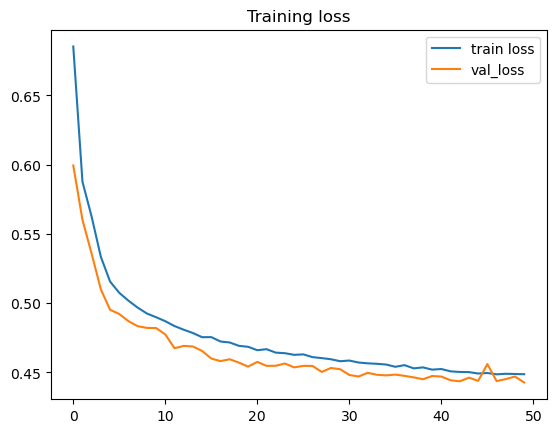

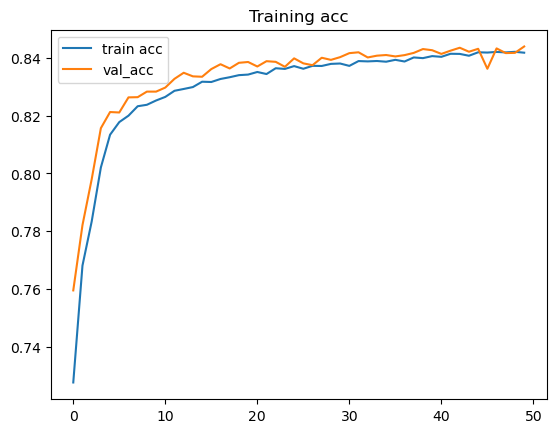

In [15]:
# Show loss curves
plt.figure()
plt.title('Training loss')
plt.plot(hist.epoch, hist.history['loss'], label='train loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig(save_folder + '/%s Training loss.pdf' %(name), format='pdf')
# plt.show()

plt.figure()
plt.title('Training acc')
plt.plot(hist.epoch, hist.history['accuracy'], label='train acc')
plt.plot(hist.epoch, hist.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig(save_folder + '/%s Training acc.pdf' %(name), format='pdf')

In [16]:
evalDict = model.evaluate(data_test,labels_test)

1785/1785 [==============================] - 2s 1ms/step - loss: 0.4422 - accuracy: 0.8452


In [17]:
# Saving dict of history and evaluation result
with open(save_folder + '/' + 'histDict', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

with open(save_folder + '/' + 'evalDict' + str(evalDict[1]), 'wb') as file_pi:
    pickle.dump(evalDict, file_pi)

In [18]:
#uncomment to save model
model.save(save_folder + '/' + name + '_Model')

INFO:tensorflow:Assets written to: template_18/one_channel_test_Model\assets


INFO:tensorflow:Assets written to: template_18/one_channel_test_Model\assets


In [19]:
Y_test = np.argmax(labels_test, axis=1) # Convert one-hot to index
y_pred = np.argmax(model.predict(data_test),axis=1)
class_names = ['Empty channel', 'Wi-Fi', 'Bluetooth']
class_report = classification_report(Y_test, y_pred, target_names=class_names)
print(class_report)

with open(save_folder + '/' + 'classReportString', 'wb') as file_pi:
    pickle.dump(class_report, file_pi)

1785/1785 [==============================] - 2s 1ms/step
               precision    recall  f1-score   support

Empty channel       0.86      0.97      0.92     35216
        Wi-Fi       0.85      0.72      0.78     11398
    Bluetooth       0.74      0.55      0.63     10488

     accuracy                           0.85     57102
    macro avg       0.82      0.75      0.78     57102
 weighted avg       0.84      0.85      0.84     57102



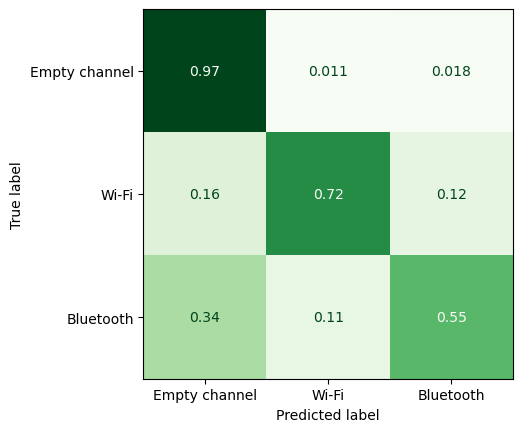

In [20]:
ConfusionMatrixDisplay.from_predictions(Y_test, y_pred, normalize='true',cmap='Greens',colorbar=False, display_labels=class_names)
plt.title('Confusion Matrix')
plt.savefig(save_folder +'/confusion_matrix_'+ name +'.pdf', format='pdf')

In [24]:
class_reportDict = classification_report(Y_test, y_pred, output_dict=True, target_names=class_names)
for key in class_reportDict:
    try:
        class_reportDict[key]['Samples'] = class_reportDict[key].pop('support')
    except Exception as e:
        print(e)
print(class_reportDict)


'float' object has no attribute 'pop'
{'Empty channel': {'precision': 0.8647596907060191, 'recall': 0.9717741935483871, 'f1-score': 0.9151490841021527, 'Samples': 35216}, 'Wi-Fi': {'precision': 0.8468874987180802, 'recall': 0.7245130724688542, 'f1-score': 0.7809352688070359, 'Samples': 11398}, 'Bluetooth': {'precision': 0.7438601002957439, 'recall': 0.5515827612509535, 'f1-score': 0.6334519572953736, 'Samples': 10488}, 'accuracy': 0.8452418479212637, 'macro avg': {'precision': 0.8185024299066144, 'recall': 0.7492900090893984, 'f1-score': 0.7765121034015207, 'Samples': 57102}, 'weighted avg': {'precision': 0.8389864752581977, 'recall': 0.8452418479212637, 'f1-score': 0.8366192859745347, 'Samples': 57102}}


In [25]:
class_reportDict.pop('accuracy')
print(class_reportDict)

{'Empty channel': {'precision': 0.8647596907060191, 'recall': 0.9717741935483871, 'f1-score': 0.9151490841021527, 'Samples': 35216}, 'Wi-Fi': {'precision': 0.8468874987180802, 'recall': 0.7245130724688542, 'f1-score': 0.7809352688070359, 'Samples': 11398}, 'Bluetooth': {'precision': 0.7438601002957439, 'recall': 0.5515827612509535, 'f1-score': 0.6334519572953736, 'Samples': 10488}, 'macro avg': {'precision': 0.8185024299066144, 'recall': 0.7492900090893984, 'f1-score': 0.7765121034015207, 'Samples': 57102}, 'weighted avg': {'precision': 0.8389864752581977, 'recall': 0.8452418479212637, 'f1-score': 0.8366192859745347, 'Samples': 57102}}


In [28]:
df = pd.DataFrame(class_reportDict).transpose().round(decimals=3)
dfi.export(df, save_folder + '/' +name + "_ClassReport.png", table_conversion="matplotlib")